Adapted from Hugging Face transformer tutorial:
https://colab.research.google.com/github/abhimishra91/transformers-tutorials/blob/master/transformers_multi_label_classification.ipynb

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import csv
csv.field_size_limit(999999)
train_df = pd.read_csv('/content/drive/MyDrive/fulltrain.csv', header = None, names=['class','text'])
test_df = pd.read_csv('/content/drive/MyDrive/balancedtest.csv', header = None, names=['class','text'])

In [5]:
# Setting up variables
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
class BERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_token_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item_index):
        text = self.texts[item_index]
        label = self.labels[item_index]

        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_token_len,
            truncation=True,
            padding="max_length",
            add_special_tokens=True,  # Adds '[CLS]' and '[SEP]'
            return_attention_mask=True,
            return_token_type_ids=True
        )

        ids = encoding['input_ids']
        mask = encoding['attention_mask']
        token_type_ids = encoding["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [7]:
X_train = train_df['text']
y_train = train_df['class'] - 1
X_test = test_df['text']
y_test = test_df['class'] - 1

In [8]:
training_set = BERTDataset(X_train, y_train, tokenizer, MAX_LEN)
testing_set = BERTDataset(X_test, y_test, tokenizer, MAX_LEN)

In [ ]:
y_train.value_counts()

class
2    17870
0    14047
3     9995
1     6942
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

class
0    750
1    750
2    750
3    750
Name: count, dtype: int64

In [9]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [10]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-cased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 4)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [11]:
loss_fn = torch.nn.CrossEntropyLoss()

In [12]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        labels = data['labels'].to(device, dtype = torch.float)

        optimizer.zero_grad()

        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, labels.long())
        if _%100==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        loss.backward()
        optimizer.step()



In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  1.5740352869033813
Epoch: 0, Loss:  0.3820655643939972
Epoch: 0, Loss:  0.269847571849823
Epoch: 0, Loss:  0.050442568957805634
Epoch: 0, Loss:  0.1647653877735138
Epoch: 0, Loss:  0.12899701297283173
Epoch: 0, Loss:  0.26018303632736206
Epoch: 0, Loss:  0.014364576898515224
Epoch: 0, Loss:  0.028641099110245705
Epoch: 0, Loss:  0.18321089446544647
Epoch: 0, Loss:  0.01869967393577099
Epoch: 0, Loss:  0.00883504282683134
Epoch: 0, Loss:  0.08157026022672653
Epoch: 0, Loss:  0.006570770405232906
Epoch: 0, Loss:  0.009513318538665771
Epoch: 0, Loss:  0.005190936848521233
Epoch: 0, Loss:  0.021730531007051468
Epoch: 0, Loss:  0.0027735710609704256
Epoch: 0, Loss:  0.12395580112934113
Epoch: 0, Loss:  0.003220569808036089
Epoch: 0, Loss:  0.004857506603002548
Epoch: 0, Loss:  0.023632295429706573
Epoch: 0, Loss:  0.007615396287292242
Epoch: 0, Loss:  0.04791181907057762
Epoch: 0, Loss:  0.0059412093833088875
Epoch: 0, Loss:  0.002798903500661254
Epoch: 0, Loss:  0.00237343

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model_weights10.pth')

In [13]:
#if loading model
model.load_state_dict(torch.load('/content/drive/MyDrive/model_weights10.pth', map_location='cuda:0'))

<All keys matched successfully>

In [14]:
model.eval()  # Set the model to evaluation mode

true_labels = []
predictions = []

with torch.no_grad():  # No need to track gradients for validation
    for batch in testing_loader:
        # Adjust these lines to match your DataLoader structure
        input_ids, attention_mask, token_type_ids, labels = batch['ids'], batch['mask'], batch['token_type_ids'], batch['labels']
        input_ids, attention_mask, token_type_ids, labels = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask, token_type_ids)
        _, predicted_labels = torch.max(outputs, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted_labels.cpu().numpy())

In [15]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       750
           1       1.00      0.72      0.83       750
           2       0.02      0.00      0.00       750
           3       0.51      0.98      0.67       750

    accuracy                           0.67      3000
   macro avg       0.59      0.67      0.60      3000
weighted avg       0.59      0.67      0.60      3000



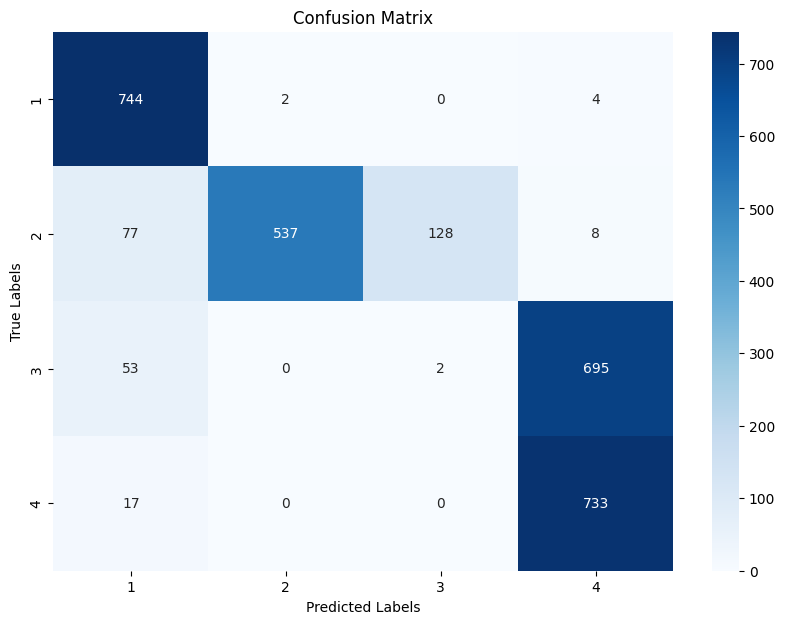

In [16]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(true_labels, predictions)

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the confusion matrix `matrix` is already computed
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()